# ViT: Vision Transformers

This notebook is demonstration and explanantion for a vision transformer. This architecture was created to use transformers which were created for language modelling, on images while at the same time changing as little of the transformer architecture as possible. The notebook will have an implementation of the vision transformer and will break down the purpose of each component in the architecture of the vision transformer. Finally it will be trained to perform a simple classification task on the large Food101 dataset.

Reference Paper: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

Prerequisites: 
- Basic understanding of Neural Networks, Transformers


## 1. Introduction:

A Vision Transformer: commonly abbreviated to ViT is transformer that has been specially designed to be used for images. Since transformers usually work with text data where they take a sequence of tokens as an input, they cannot be directly used for the task of working with images. Vision transformers take the image as a sequence of patches. These patches are then fed through the network and the learned representations can then be used for any downstream task. 

The ViT is an encoder only transformer, i.e, it is used to give embeddings of the images that are fed to it, these embeddings are then used for any downstream task, like segmentation, classification e.t.c.


## 2. Architecture

<br>
<center><img src="https://viso.ai/wp-content/uploads/2021/09/vision-transformer-vit.png", width="50%"></center>
<br>

In the image given above we can see the architecture of the ViT. Lets walk through the components and their purpose: -

1. **Patch Embedding:** The patch embedding is responsible for taking each patch of the image and giving an n dimensional embedding. This is similar to how words were embedded in the transformer. The patch embedding is such that after training similar patches will be given similar embeddings.

2. **Positional Embedding:** just like in text where we needed to give positional encoding to the words so that they knew where they were lying, similarly we must do so in images as well. Spatial information of the patches is very important and must be preserved, this is because when the patches are fed to a transformer, all patches interact with each other in a global manner, this is unlike convolutional neural networks where filters are used to ensure only pixels in a neighborhood interact to give output, due to the nature of transformers as a result we need to have positional embedding as well. We add this positional embedding to the patch embedding result of each patch to give us the final patch embeddings.

3. **Transformer Encoder**: the transformer encoder takes in the embeddings and gives an output which are the learned representations of the patches, this contains useful information like the relationships of the patches with each other, like for example what patch is likely to follow a given patch etc. The components of the transformer encoder are as follows: -

    * **Multi-Headed Attention**: attention is the backbone of a transform, it gives us useful information of each individual token. Attention is made up of key, query and value. Where query is for example your patch query, key is for all the other patches in the sequence and their product represents how much your patch is related to to other pathces in the sequence. Finally value is also used, value contains useful information about your specific patch. They all have the same sized embeddings. It is called multi headed attention as there are multiple heads working in parallel which give the final result.

    * **MLP**: the multi-layer perceptron is simply a linear projection of the results of our multi headed attention, it is useful for various reasons such as introducing non-linearity, extracting useful features e.t.c.

    * **Layer Norm**: layer norm is applied to the input before being fed to mlp and attention, it normalises the values across a column ensuring stability during training.

4. **MLP Head**: Finally the mlp head is a projection head that works on the result of the transformer as a whole to perform a downstream task for example classification. The MLP head works only on one patch from the entire sequence of patches that is generated as output of the model. This singular patch can be either a CLS token or it can be created by taking a global average pooling of all the patches.

5. **CLS Token**: the CLS token is a special token that is the same dimensionality as patches after their embedding and it is prepended to the sequence of patches before they are fed to the transformer, a CLS token does not have a positional encoding. The idea for a CLS token is that it will act as a global information holder and will contain an aggregate result of the entire image after training. In some implementation it is used as input to the MLP head for the final task.



## 3. Implementation

In this section we will implement the ViT, and with the help of comments and some documentation explain the reasoning behind the code. Lets first start off with downloading the dataset and exploring it as well as creating various functions that we need to prepare our data to be used in the ViT

### 3.1 Data Exploration and Preparation:

For this section our goal is to perform the following: -

1. Download Dataset: CIFAR10 used for this implementation
2. Create data transformer, loader
3. Create function to prepare an image for it to be used as input to model
4. Create function to visualise an image

In [1]:
import torchvision
import torch
import torch.nn as nn 
import torchvision.transforms as transforms
import torch.nn.functional as F 
import numpy as np 
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader, random_split 
from time import time

/Users/rishabhrao/opt/miniconda3/envs/dl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMG_HEIGHT = 64
IMG_WIDTH = 64
batch_size=64

In [3]:
transformer = transforms.Compose([
    transforms.Resize(size=(IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transformer)
valset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transformer)

trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, drop_last=True)
valloader = DataLoader(dataset=valset, batch_size=batch_size, shuffle=False, drop_last=True)

print(f"Trainset Length: {len(trainset)}")
print(f"Valset Length: {len(valset)}")

Files already downloaded and verified
Files already downloaded and verified
Trainset Length: 50000
Valset Length: 10000


In [4]:
# Get one batch of images for testing purposed

images, labels = next(iter(trainloader))
print(images.shape) # (B, C, H, W) -> Batch, Channel, Height, Width (this convention will be used)
print(labels.shape) # (B,) -> Batch

torch.Size([64, 3, 64, 64])
torch.Size([64])


In [5]:
def visualise_img(data):
    # data -> (C, H, W)
    img = data.detach().numpy().transpose(1, 2, 0) # to take C to last channel
    mean = np.array([0.49139968, 0.48215827 ,0.44653124])
    std = np.array([0.24703233, 0.24348505, 0.26158768])
    img = std*img + mean
    img = np.clip(img, 0, 1)
    return img

(-0.5, 63.5, 63.5, -0.5)

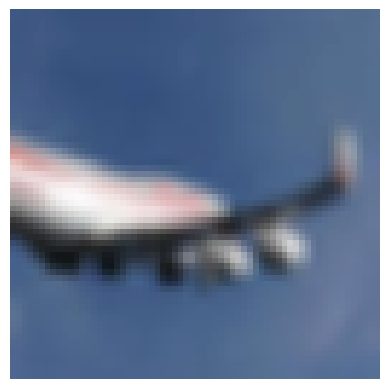

In [6]:
plt.imshow(visualise_img(images[1]))
plt.axis('off')

In [7]:
patch_h = 4
patch_w = 4
num_patches = (IMG_HEIGHT // patch_h) ** 2

In [8]:
# Create function to get image patches

def get_patches(imgs):
    B, C, H, W = imgs.shape
    patches = imgs.unfold(2, patch_h, patch_h).unfold(3, patch_w, patch_w)
    patches = patches.contiguous().view(B, C, -1, patch_h, patch_w) # (B, C, P, h, w)
    patches = patches.permute(0, 2, 1, 3, 4)
    return patches

In [9]:
def prepare_images(imgs):
    patches = get_patches(imgs)
    B, P, C, h, w = patches.shape
    patches_flat = patches.reshape(B, P, C*h*w)
    return patches_flat

In [10]:
# Running prepare images function: -

print(f"Input images: {images.shape}")
print(f"Input to ViT: {prepare_images(images).shape}")

Input images: torch.Size([64, 3, 64, 64])
Input to ViT: torch.Size([64, 256, 48])


This works perfectly as we need the ViT to get the input of the images as flattened patches. Now we can get started on the implementation of the actual model.

### 3.2 Model Implementation:

For this section our goal is to perform the following: -

1. Construct the ViT and all its components
2. Train the model on our image data
3. Evaluate the model performance on test set

In [11]:
patches = prepare_images(images)
patches.shape

torch.Size([64, 256, 48])

In [12]:
eval_iters = 50

In [13]:
@torch.no_grad()
def get_losses():
    """Get loss for train and val split

    Returns:
        _type_: _description_
    """
    model.eval()
    out = {}
    for split in ['train', 'val']:
        loader = trainloader if split == 'train' else valloader
        losses = torch.zeros(eval_iters)
        k = 0
        for images, labels in iter(loader):
            patches = prepare_images(images)
            cls_patch, loss = model(patches, labels)
            losses[k] = loss.item()
            k += 1
            if k == eval_iters:
                break
        out[split] = losses.mean()
    model.train()
    return out

In [14]:
class Head(nn.Module):
    """Single head of attention for transformer

    Args:
        nn (_type_): built on nn.Module
    """

    def __init__(self, n_embd, head_size) -> None:
        super().__init__()
        self.key = nn.Linear(n_embd, head_size) # this represents the other patches think of them as tags
        self.query = nn.Linear(n_embd, head_size) # this represents the tokens as queries
        self.value = nn.Linear(n_embd, head_size) # information about each token
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # Since this is self attention k,q,v are all made from x itself
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) / (k.size(-1) ** 0.5)  
        wei = F.softmax(wei, dim=-1) # probability of each patch wrt other patches
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v # adds individual information of each token to the interrelated information found
        return out
    

class MultiHeadedAttention(nn.Module):
    """Multi-headed attention for transformer

    Args:
        nn (_type_): _description_
    """

    def __init__(self, n_embd, num_heads) -> None:
        super().__init__()
        assert n_embd % num_heads == 0, f"Embedding size: {n_embd} not divisible num of heads: {num_heads}"
        self.head_size = n_embd // num_heads
        self.heads = nn.ModuleList([Head(n_embd, self.head_size) for _ in range(num_heads)])
        self.c_proj = nn.Linear(n_embd, n_embd)
    
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # Multiple heads give out of head_size which when concatenated become -> n_embd
        out = self.c_proj(out)
        return out
    
class MLP(nn.Module):
    """Multi-Layer Perceptron within Transformer Encoder Block

    Args:
        nn (_type_): _description_
    """

    def __init__(self, n_embd) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.GELU(),
            nn.Linear(4*n_embd, n_embd),
            nn.Dropout(0.2)
        )
    
    def forward(self, x):
        out = self.net(x)
        return out
    
class TransformerEncoder(nn.Module):
    """Transformer Encoder Block

    Args:
        nn (_type_): _description_
    """

    def __init__(self, n_embd, num_heads) -> None:
        super().__init__()
        self.attn = MultiHeadedAttention(n_embd, num_heads)
        self.mlp = MLP(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    
    def forward(self, x):
        x = x + self.attn(self.ln1(x)) # this is a residual skip connection, it allows gradients to flow back easily to input
        x = x + self.mlp(self.ln2(x)) # you can see the fact that input is added to output of attn and mlp in the diagram given
        return x

class MLPHead(nn.Module):
    """MLP Projection Head for classification

    Args:
        nn (_type_): _description_
    """

    def __init__(self, n_embd, num_classes) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.Tanh(),
            nn.Linear(4*n_embd, num_classes)
        )
    
    def forward(self, x):
        x = self.net(x)
        return x

def get_position_enc(num_patch, n_embd):
    """Gives sinusoidal positional encodings

    Args:
        nn (_type_): _description_
    """
    assert n_embd % 2 == 0, f"{n_embd} should be even for positional encoding"

    y_pos = torch.arange(0, num_patch, dtype=torch.float).unsqueeze(1)
    x_pos = torch.arange(0, num_patch, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, n_embd // 2, 2).float() * (-torch.log(torch.tensor(1000.0)) / (n_embd // 2)))

    pos_encoding = torch.zeros((num_patch, n_embd))
    pos_encoding[:, 0::4] = torch.sin(y_pos * div_term)
    pos_encoding[:, 1::4] = torch.cos(y_pos * div_term)
    pos_encoding[:, 2::4] = torch.sin(x_pos * div_term)
    pos_encoding[:, 3::4] = torch.cos(x_pos * div_term)

    return pos_encoding

class ViT(nn.Module):
    """Vision Transfomer

    Args:
        nn (_type_): _description_
    """

    def __init__(self, num_patches, n_embd, num_heads, num_enc_blocks, num_classes) -> None:
        super().__init__()
        self.patch_embedding = nn.Linear(3*patch_h*patch_w, n_embd) # embeds the patches
        self.pos_encoding = get_position_enc(num_patches, n_embd) # adds positional information to patches
        self.encoder = nn.Sequential(*[TransformerEncoder(n_embd, num_heads) for _ in range(num_enc_blocks)]) # xL number of encoder blocks
        self.mlp_head = MLPHead(n_embd, num_classes) # linear projection head for classification
        self.cls_token = nn.Parameter(torch.randn(size=(1, n_embd))) # special token for aggregating global information

    def forward(self, x, y=None):
        patch_embd = self.patch_embedding(x)
        patch_embd += self.pos_encoding # (B, P, n_embd)
        cls_tokens = self.cls_token.expand(size=(64, *self.cls_token.shape)) # (B, 1, n_embd)
        tokens = torch.cat([cls_tokens, patch_embd], dim=1) # (B, P+1, n_embd)
        representations = self.encoder(tokens) # (B, P+1, n_embd)
        cls_patch = representations[:, 0, :] # (B, n_embd)
        logits = self.mlp_head(cls_patch) # logits of each class
        
        if y is None:
            return cls_patch, logits # if labels not provided i.e, we are performing inference we want logits
        else:
            loss = F.cross_entropy(logits, y) # performs softmax and then negative log likelihood to find loss
            return cls_patch, loss


In [15]:
eval_interval = 500
num_epochs = 5

In [173]:
model = ViT(num_patches, n_embd=80, num_heads=5, num_enc_blocks=3, num_classes=10)
optimizer = torch.optim.AdamW(lr=1e-3, params=model.parameters())
curr_iter = 0
losses = []
print(f"Number of total parameters: {sum([torch.numel(p) for p in model.parameters()])}") 

Number of total parameters: 266650


In [174]:
# To train the model

for epoch in range(num_epochs):
    for images, labels in iter(trainloader):
        patches = prepare_images(images) # Get patched images
        cls_patch, loss = model(patches, labels) # Get cls patch and loss

        if curr_iter % eval_interval == 0:
            t1 = time()
            losses_split = get_losses() # Get loss on train and validation set
            t2 = time()
            print(f"Step {curr_iter}: Train Loss: {losses_split['train']:.4f} Val Loss: {losses_split['val']:.4f} Time Taken: {t2-t1} seconds")
            
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        curr_iter += 1
        losses.append(loss.item())

Step 0: Train Loss: 2.3341 Val Loss: 2.3394 Time Taken: 33.352516174316406 seconds
Step 500: Train Loss: 1.4766 Val Loss: 1.4751 Time Taken: 36.70573306083679 seconds
Step 1000: Train Loss: 1.3068 Val Loss: 1.3523 Time Taken: 37.27702522277832 seconds
Step 1500: Train Loss: 1.1625 Val Loss: 1.2234 Time Taken: 38.03956198692322 seconds
Step 2000: Train Loss: 1.1072 Val Loss: 1.1718 Time Taken: 38.41781306266785 seconds
Step 2500: Train Loss: 1.0476 Val Loss: 1.1324 Time Taken: 39.27655386924744 seconds
Step 3000: Train Loss: 0.9879 Val Loss: 1.0955 Time Taken: 38.98239612579346 seconds
Step 3500: Train Loss: 0.9900 Val Loss: 1.0808 Time Taken: 37.32664608955383 seconds


In [175]:
# torch.save(model, '../SavedModels/vit.pth')

In [16]:
model = torch.load('../SavedModels/vit.pth')

### 3.3 Model Evaluation

We will check classification report to see how good the model is at learning, and use metrics like classwise precision, accuracy, recall and the f1 score to see how well our model is performing.

In [17]:
from sklearn.metrics import classification_report

In [18]:
print(len(valset))

10000


In [22]:
for images, labels in iter(valloader):
    patches = prepare_images(images) # Get patched images
    cls_patch, logits = model(patches) # Get cls logits and loss
    probs = F.softmax(logits, dim=-1)
    preds = probs.argmax(dim=-1)
    print(classification_report(labels, preds))
    break
    

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.50      1.00      0.67         3
           2       0.20      0.50      0.29         2
           3       0.50      0.50      0.50         6
           4       0.38      0.50      0.43         6
           5       0.50      0.43      0.46         7
           6       0.82      0.82      0.82        11
           7       1.00      0.57      0.73         7
           8       0.75      0.86      0.80         7
           9       1.00      0.89      0.94         9

    accuracy                           0.66        64
   macro avg       0.66      0.64      0.61        64
weighted avg       0.73      0.66      0.66        64



## 4. Understanding and Exploring Model Predictions